In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

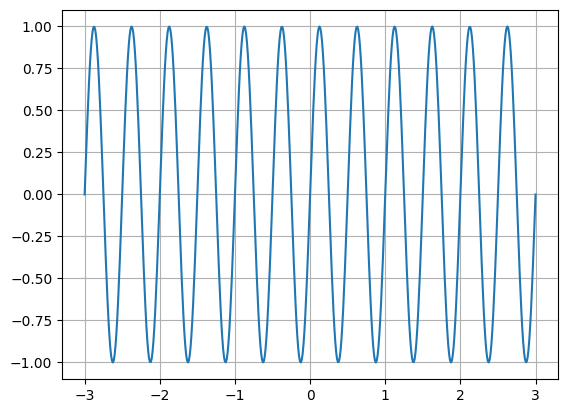

In [3]:
x = torch.linspace(-3, 3, 512)
u = torch.sin(4*torch.pi * x)

plt.plot(x, u)
plt.grid()
plt.show()

In [4]:
from pinns import Domain
from pinns.samplers import ConstantSampler, RandomSampler

pts = torch.tensor([x[0], x[-1]]).reshape(-1, 1)
vals = torch.tensor([u[0], u[-1]]).reshape(-1, 1)
constraints_sampler = ConstantSampler((pts, vals))

domain = Domain({'x': [-3, 3]})
collocation_sampler = RandomSampler(domain, 2048, return_dict=False)

test_points_sampler = ConstantSampler((
    x.reshape(-1, 1), u.reshape(-1, 1)
))

In [5]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred
    ):
    
    def boundary_loss(u, x):
        return torch.mean(torch.square(u - cstr_vals))

    def ode_loss(u, x):
        uxx = d(u, x, orders = 2)
        return torch.mean(torch.square(uxx + 16*torch.pi**2 * torch.sin(4*torch.pi*x)))
    
    losses = (
        boundary_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [6]:
ip_pts, ip_vals = test_points_sampler()
ip_pts.requires_grad_(True)

def residual(u, x):
    uxx = d(u, x, orders = 2)
    return torch.square(uxx + 16*torch.pi**2 * torch.sin(4*torch.pi*x))

In [14]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin, Swish
from pinns.optimizers import Adam
from pinns.metrics import l2, mse
from pinns.analyze import InformationPropagation

# Kaiming normal somehow force loss to decrease and error to increase.
pinn = FF([1] + [64] + [1], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()} trainable parameters.')
init_params, _ = pinn.get_parameters_vector()

adam = Adam(pinn, lr = 1e-2)

ip = InformationPropagation(
    points = ip_pts, 
    values = ip_vals,
    domain = domain, 
    strategy = 'both',
    compute_every=5,
    residual = residual,
    group_at_finish = True,
    first_initial=False
)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],
    analyzers = [ip]
)

num_iters = 4000
def make_plot():
    if trainer.iter == 0 or trainer.iter % 5 == 0 or trainer.iter == num_iters:
        preds = pinn.predict(test_points_sampler()[0]).detach()
        np.save(f'./.temp/poisson_{trainer.iter}.npy', preds.numpy())

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    training_start_callbacks=[make_plot],
    epoch_end_callbacks=[make_plot]
    )
torch.save(pinn.model, './ps4000.pt')

Model has {'total': 193, 'trainable': 193} trainable parameters.


  0%|          | 0/4000 [00:00<?, ?it/s]

In [15]:
from PIL import Image
import imageio
from joblib import Parallel, delayed

from tqdm.notebook import tqdm_notebook as tqdm

def save_animation(files, path, duration=5, fps=60, loop=0, type='mp4', processors=2, ):
    
    fig = plt.figure(figsize=(5, 3))
    xlim = x.min(), x.max()
    
    def plot(i):
        predictions = np.load(files[i])
        # Set plot limits and labels
        plt.xlim(xlim)
        plt.plot(x, u, label='Solution')
        plt.plot(x, predictions, label='Predicts', linestyle=':')
        plt.grid()
        # plt.legend()
        fig.savefig(f'./.temp/frame_{i}.png', dpi=300)
        fig.clear()
        
    # Number of frames
    num_frames = len(files)

    # Parallelize the plotting function
    Parallel(n_jobs=processors, verbose=4)(delayed(plot)(i) for i in range(num_frames))
    
    if type == 'mp4':
        writer = imageio.get_writer(path, fps=fps)
        for i in range(len(files)):
            writer.append_data(imageio.imread(f'./.temp/frame_{i}.png'))
        writer.close()
        
    if type == 'gif':
        imgs = [Image.open(f'./.temp/frame_{i}.png') for i in range(len(files))]
        imgs[0].save(path, save_all=True, append_images=imgs[1:], duration=duration, fps=fps, loop=loop)
    
files = [f'./.temp/poisson_{i}.npy' for i in range(0, trainer.iter, 25)]
save_animation(files, './.results/poisson animation.gif', type='gif', processors=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    7.6s finished


<Figure size 500x300 with 0 Axes>

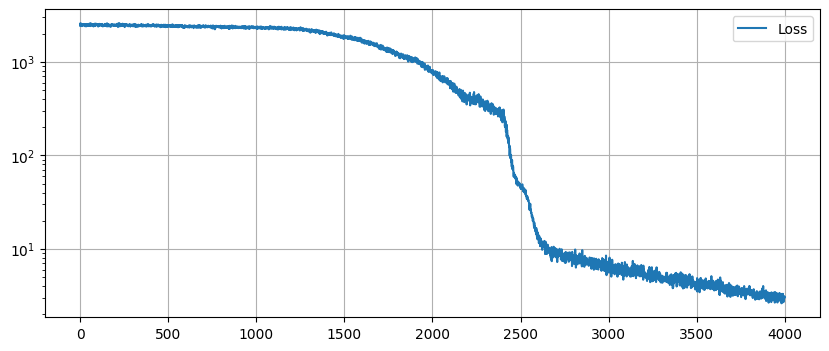

In [16]:
trainer.plot()

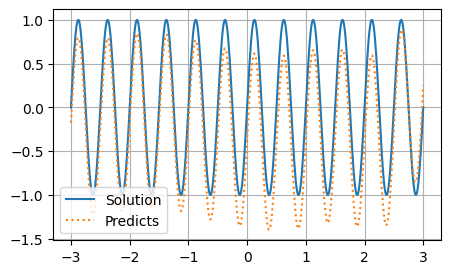

In [17]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig = plt.figure(figsize=(5, 3))

preds = pinn.predict(x.reshape(-1, 1))
plt.plot(x, u, label='Solution')
plt.plot(x, preds.detach(), label='Predicts', linestyle=':')
plt.grid()
plt.legend()

plt.show()

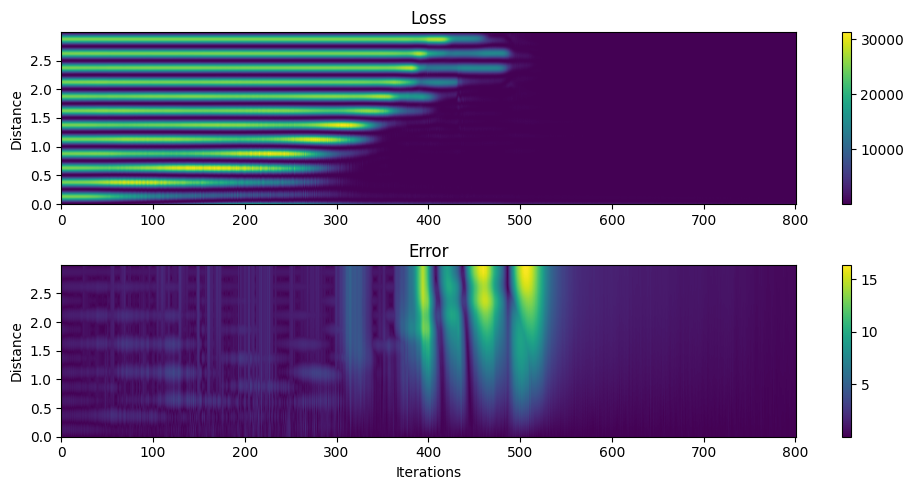

In [18]:
ip.plot()

In [12]:
R = (pinn.get_parameters_vector()[0] - init_params).norm(p=2)

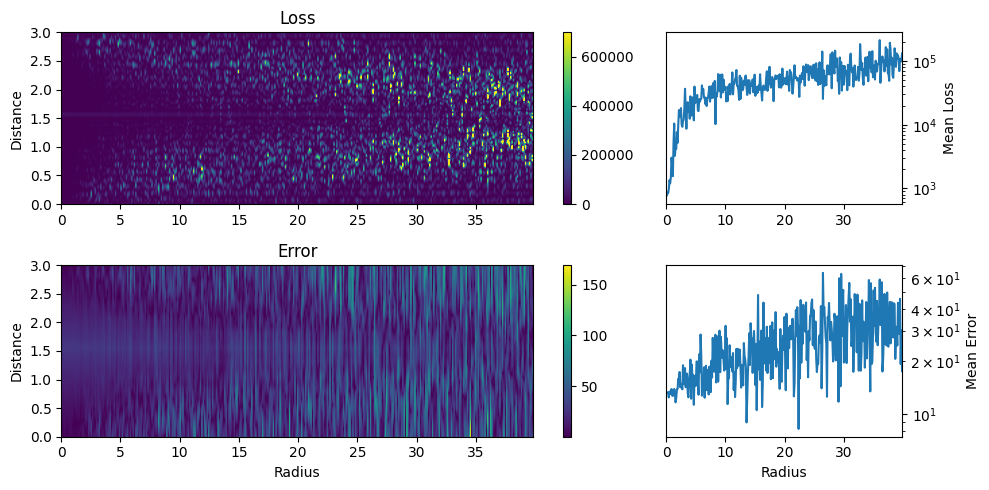

In [13]:
pinn.model = torch.load('./ps4000.pt')
ip.pplot(pinn, R = R * 0.5, num_points=350, loss_vmax = 7e5)